# COGS 108 - Final Project 

# Overview

In this project I explored whether or not there are disparities of cleanliness between Wake County restaurants in high income areas and restaurants that are not. I performed two t-tests and got polarizing results. 

# Name & PID

- Name: Nancy Vuong
- PID: A13572030

# Research Question

Is there a relationship between the average wealth of a restaurant's location and how much critical health violations it made? 

## Background and Prior Work

In 2014, a consumer report surverying 1003 people about their restaurant complaints. The most common complaints about eating at restaurants people had were hygeine related, such as having "dirty utensils and tables", "dirty or ill-equiped bathrooms", or having "servers with sloppy appearance and poor hygiene". All of these reasons are also health violations according to the California Retail Food Code, for obvious reasons.


A study done in 2016 found a way to detect high-health-risk restaurants from Yelp reviews and found that Yelp reviews that complain about a restaurant's hygiene is tend to not contain the word "affordable". This has led me to wonder if wealth plays a role in a restaurant's overall cleanliness. 

References:
- 1) Consumer Report https://www.consumerreports.org/cro/magazine/2014/08/most-common-restaurant-complaints/index.htm
- 2) Supplementing Public Health Inspection via Social Media https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4811425/

# Hypothesis


Being located in wealthier areas does affect how many critical health violations health violations a restaurant makes.

# Dataset(s)

- Dataset Name: restaurants.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?preview=1639871
- Number of observations: 3324
This dataset contains information of restaurants in Wake County, North Carolina. Each row is a restaurant with its own individual id and contains location like its name, address, zip code.

- Dataset Name: violations.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?preview=1639871
- Number of observations: 189802
This dataset contains information on each health code violation a restaurant in Wake County. Each row represent one violation and the columns contain information about that violation like how severe it was, what restaurant made that violation, and if the violation was critical. The only columns I found to be important were restaurant id and if the violation was critical as I found that restaurants make tons of small violations all the time, but the critical ones are the ones that should be worried about.

- Dataset Name: zipcodes.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?preview=1639871
- Number of observations: 38
This dataset contains information on every zipcode in Wake County. Each observation is a zip code and the columns contain information about that zip code like the median household income of that zip code.

I plan on combining the restaurant and violations dataset by left joining them on the unique id of the restaurant. I then combine that merged dataframe with the zipcodes dataset by inner joining them on the zip codes of the restaurant.

# Setup

In [115]:
## YOUR CODE HERE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import pearsonr, norm, ttest_ind, zscore
import warnings
warnings.filterwarnings('ignore')

restaurants = pd.read_csv("data/restaurants.csv")
violations = pd.read_csv("data/violations.csv")
zipcodes = pd.read_csv("data/zipcodes.csv")

# Data Cleaning

A quick look at the restaurants dataset shows that some of the zip codes it contains exceeds 5 digits.

In [2]:
restaurants.head()

,X.objectid,hsisid,name,address1,address2,city,state,postalcode,phonenumber,restaurantopendate,facilitytype,x,y,geocodestatus
0,1001,4092017230,SPRING CAFE 2,2900-104 SPRING FOREST RD,NaN,RALEIGH,NC,27616-1895,(919) 977-3679,2016-05-26T00:00:00.000Z,Restaurant,-78.591634,35.855487,M
1,1002,4092040338,CAROLINA CLASSIC HOT DOGS #2 (WCID #549),309 HOLLOMAN ST,NaN,APEX,NC,27502,NaN,2016-07-01T00:00:00.000Z,Pushcarts,-78.855348,35.730219,M
2,1003,4092014444,Taco Bell #22798,2207 S MAIN ST,NaN,WAKE FOREST,NC,27587,(919) 554-4924,2005-12-05T00:00:00.000Z,Restaurant,-78.536145,35.946695,M
3,1004,4092015333,THE REMEDY DINER,137 E HARGETT ST,NaN,RALEIGH,NC,27601,(919) 835-3553,2009-02-04T00:00:00.000Z,Restaurant,-78.636895,35.777999,M
4,1005,4092160069,ZEBULON HOUSE (KITCHEN),551 PONY RD,NaN,ZEBULON,NC,27597,NaN,2009-02-18T00:00:00.000Z,Institutional Food Service,-78.332138,35.816779,M


This conflicts with the formatting of the zip codes from the zipcodes data where all the zip codes there are only 5 digits. This means I need to clean the postalcode column of the restaurants data so the values there only contain the first 5 digits and also convert the values to int because the zip codes in the zipcode data are in int while the ones in the restaurant data are in string. While I am at it I will reduce the restaurant dataset to only the hsisid (the unique id of a restaurant) and postalcode as they are all what I need from the restaurants dataset.

In [9]:
rest = restaurants[["hsisid", "postalcode"]]
rest["postalcode"] = rest["postalcode"].apply(lambda x: int(x[:5]))

Similarily I am cleaning the violations data by reducing it to only the hsisid and the critical column as those are all I need. Since the values of the critical column are only either "Yes" or "No" I will clean this column by converting all "Yes"'s to 1 and "No"'s to 0 since this will make it easier to count the number of critical violations later.

In [10]:
vio = violations[["hsisid", "critical"]]
vio["critical"] = vio["critical"].apply(lambda x: 1 if x == "Yes" else 0)

I reduced the zipcodes dataset to just the zip and median_household_income_dollars column. I then merge all three dataframes. I chose to apply a left join on the restaurant and the violations dataframe since I figured that not all restaurants would have made a health code violation and some health code violations could be made by restaurants that were no longer open.

Since some restaurants did not make any health violations, the corresponding value of the restaurant to the critical column would be NaN so I had to fill those NaN values with 0s. This makes sense as a restaurant with no critical health violations would have 0 critical health violations.

In [14]:
zips = zipcodes[["zip", "median_household_income_dollars"]]
restviozip = rest.merge(vio, how = "left", on = "hsisid").merge(zips, how = "inner", 
                                                                left_on = "postalcode",
                                                               right_on = "zip")
restviozip["critical"] = restviozip["critical"].fillna(0)
restviozip.head()

,hsisid,postalcode,critical,zip,median_household_income_dollars
0,4092017230,27616,1.0,27616,56323
1,4092017230,27616,1.0,27616,56323
2,4092017230,27616,1.0,27616,56323
3,4092017230,27616,1.0,27616,56323
4,4092017230,27616,1.0,27616,56323


# Data Analysis & Results

Here I find the total number of critical violations made by each restaurant and display it in  a groupby dataframe with the median household income of the restaurant's location. The values in the "critical" column are now the total number of critical health violations of each restaurant.

In [32]:
vio_per_rest = restviozip.groupby("hsisid").agg({'critical': 'sum', 
                                                              'median_household_income_dollars': "max"})
vio_per_rest.head()

,critical,median_household_income_dollars
hsisid,,
4092010024,13.0,53825
4092010031,10.0,50365
4092010035,9.0,67392
4092010037,12.0,50868
4092010046,16.0,50365


I wanted to see if I could perform a linear regression with the variables median_household_income_dollars and critical. One of the requirements of performing linear regression is that the two variables must have a linear relationship. To visualize this I made a scatterplot of the data with median_household_income_dollars as the x axis and critical on as the y-axis.

Text(0.5, 1.0, 'Number of violations by median income of location')

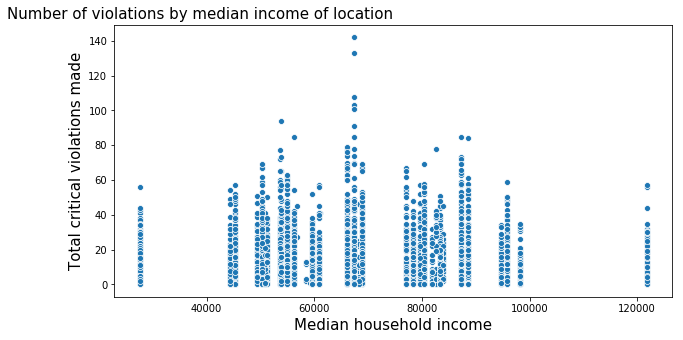

In [33]:
plt.figure(figsize=(10,5))
income_violations_plot = sns.scatterplot("median_household_income_dollars", "critical", 
                                         data=vio_per_rest)
income_violations_plot.set_xlabel('Median household income', fontsize=15)
income_violations_plot.set_ylabel('Total critical violations made', fontsize=15)
#income_violations_plot.set_title("Number of violations by median income of location")
plt.title("Number of violations by median income of location", ha="right", fontsize=15)

The scatterplot shows that the two variable do not have a linear relationship so I could not perform linear regression as is. Though since there is a peak in the scatterplot, I decided that I could split the median_household_income_dollars data at somewhere near the peak which seems to be 70000. I splitted the data so that areas with a median income lower than 70000 is counted as low income and areas with a higher or equal to 70000 median income is considered as high income. This is so I can perform a t-test on the two data to see if there is a difference in means of critical violations made between the two income groups.

In [38]:
restviozip["high_income"] = restviozip["median_household_income_dollars"].apply(lambda x: 0 if x < 70000 else 1)
vio_per_rest = restviozip.groupby("hsisid").agg({'critical': 'sum', "high_income": "max"})
vio_per_rest.head()

,critical,high_income
hsisid,,
4092010024,13.0,0
4092010031,10.0,0
4092010035,9.0,0
4092010037,12.0,0
4092010046,16.0,0


Here are the two box plots to visualize if there is difference amongst the distribution of the two income groups. The two distributions seem to be the same. The box plots also exposed outliers amongst the two distributions so I got rid of those in the next cell.

Text(0, 0.5, 'Number of critical violations made')

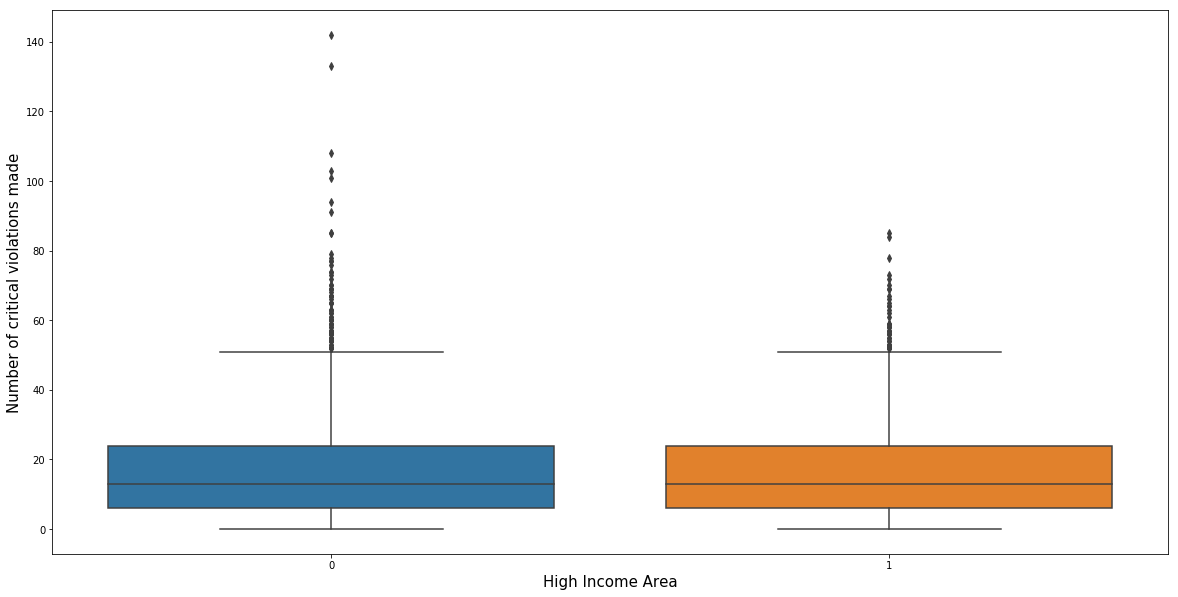

In [178]:
plt.figure(figsize=(20,10))
boxes = sns.boxplot(x='high_income', y='critical', data=vio_per_rest)
boxes.set_xlabel('High Income Area', fontsize=15)
boxes.set_ylabel('Number of critical violations made', fontsize=15)

In [122]:
grouped_df = vio_per_rest.reset_index(drop = False)
group1 = grouped_df.loc[grouped_df["high_income"]==0]
group1 = group1[np.abs(group1["critical"]-group1["critical"].mean())<=(3*group1["critical"].std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
group1 = group1[~(np.abs(group1["critical"]-group1["critical"].mean())>(3*group1["critical"].std()))]

group2 = grouped_df.loc[grouped_df["high_income"]==1]
group2 = group2[np.abs(group2["critical"]-group2["critical"].mean())<=(3*group2["critical"].std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
group2 = group2[~(np.abs(group2["critical"]-group2["critical"].mean())>(3*group2["critical"].std()))]

Here is where I performed the t-test to check if there is a difference in the means of total critical violations between the two income groups. My hypotheses are:

$H_0: \bar x_{HighIncomeTotalCriticalViolations} = \bar y_{NotHighIncomeTotalCriticalViolations}$

$H_a: \bar x_{HighIncomeTotalCriticalViolations} \ne \bar y_{NotHighIncomeTotalCriticalViolations}$

with alpha = 0.05.

In [124]:
ttest_ind(group1["critical"], group2["critical"])

Ttest_indResult(statistic=0.26103915923392396, pvalue=0.7940793680552078)

The p-value from this t-test is greater than alpha so I fail to reject the null hypothesis meaning that that the means between the groups are the same and that being located in a wealthy area does not affect how many critical health violations a restaurant makes.

However I later realized that one assumption that has to be made for t-testing is the the dependent variable has to follow a normal distribution. I checked if this does and it is actually very skewed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2f8745f8>]],
      dtype=object)

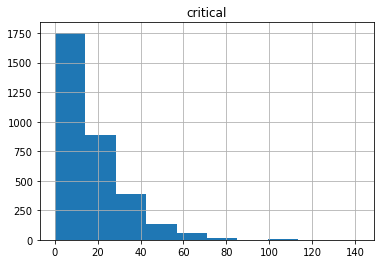

In [157]:
vio_per_rest.hist("critical")

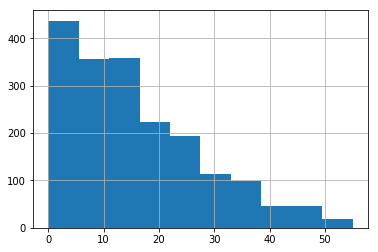

In [158]:
group1["critical"].hist()

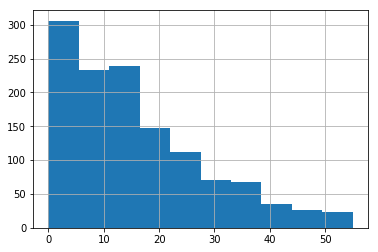

In [159]:
group2["critical"].hist()

To remedy this I attempted to implement bootstrap resampling to get samples that follow the normal distribution.

In [170]:
def bootstrap(group):
    avgs = []
    for i in np.arange(10000):
        random_sample = group.sample(len(group), replace = True).values
        new_average = np.average(random_sample)
        avgs.append(new_average)
    return avgs

(array([4.100e+01, 2.570e+02, 1.033e+03, 2.310e+03, 3.013e+03, 2.143e+03,
        9.260e+02, 2.410e+02, 3.400e+01, 2.000e+00]),
 array([14.66649049, 14.88255814, 15.09862579, 15.31469345, 15.5307611 ,
        15.74682875, 15.96289641, 16.17896406, 16.39503171, 16.61109937,
        16.82716702]),
 <a list of 10 Patch objects>)

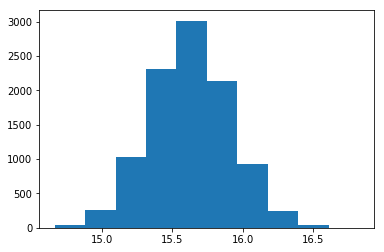

In [171]:
new_samp1 = bootstrap(group1["critical"])
plt.hist(new_samp1)

(array([  14.,  145.,  808., 2020., 3067., 2436., 1194.,  280.,   32.,
           4.]),
 array([14.1998414 , 14.48025377, 14.76066614, 15.04107851, 15.32149088,
        15.60190325, 15.88231562, 16.16272799, 16.44314036, 16.72355274,
        17.00396511]),
 <a list of 10 Patch objects>)

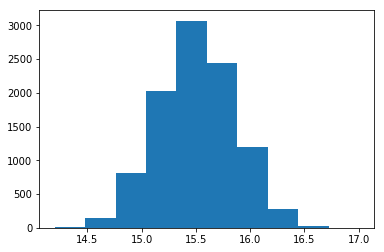

In [172]:
new_samp2 = bootstrap(group2["critical"])
plt.hist(new_samp2)

In [176]:
print("mean violations of high income areas: ", sum(new_samp1)/len(new_samp1))
print("mean violations of not high income areas: ", sum(new_samp2)/len(new_samp2))

mean violations of high income areas:  15.63016020084566
mean violations of not high income areas:  15.50822085646318


Now that I acquired samples that follow a normal distribution, I used them to perform another t-test with the same hypotheses and alpha. 

In [175]:
ttest_ind(new_samp1, new_samp2)

Ttest_indResult(statistic=26.89828302073443, pvalue=1.3957519761089205e-156)

The p-value from this t-test is less than alpha so I reject the null hypothesis meaning in favor of the alternative hypothesis. That the means between the groups are not the same and that being located in a wealthy area does affect how many critical health violations a restaurant makes.

# Ethics & Privacy

I did not present the actual names of any restaurants and businesses with their health inspection scores and violations they may have made to avoid the defamation and the slandering of them. The data I used does not violate any privacy concerns because Wake County publically publishes their health inspection results.

# Conclusion & Discussion

To summarize my question was whether or not there is a relationship between how wealthy a restaurant's location is and how many critical health violations it makes. My hypothesis was that the overall wealth of a restaurant's location does affect how much critical health violation it makes. To find out whether this was true, I splitted my original dataset into critical health violations made by restaurants in high income neighborhoods and low income neighborhoods to perform a t-test. The latter t-test results show that being located in a wealthy area does affect how many critical health violations a restaurant makes.

One limitation this project has is that I am not sure if I performed bootstrap resampling correctly. The fact that the p-values of the two t-tests are so different also play a part in my uncertainty and that the results of the initial t-test fits so well with the boxplot. Also just from looking at histograms of the resampled data, you can already tell that the means between the two groups are really close to each other (they actually are if you go look at cell 176). Yet despite the distributions of the two groups being so similar, the t-test gave back a really low p-value which makes me think that the resampling was not (only) the part that has errors in it. Nonetheless I am more inclined to trust the initial t-test results more.

Another limitation is that Wake County is actually the richest county in North Carolina so I do not consider the metric I used to classify areas as low income in this project (less than $70000) to be accurate to reality. In the future it would be best to explore my research question with data from counties with more varying degrees of wealth.

In the case of being located in a weatlhy area not affecting how much critical violations a restaurant makes, I guess it would make sense if you consider that low income areas typically have less access to healthier food sources and urban areas especially have an abundance of fast food restaurants. These fast food restaurants are often part of a chain of restaurants and they need to maintain the aesthetic of cleanliness for corporate standards. This could also mean that people should not judge a restaurant by its location. In the opposite case of a wealthy location affecting number of critical violations made, one possible reason for this is that the main selling point of these restaurants is their ambiance. In the future, I would like to research if there is a relationship between how expensive a restaurant is and the number of violations it made.